# BLOC 4 - DISASTER TWEETS

##### Coralie GUILLOTTE - DSMFT-paris-20

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, SimpleRNN
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from spacy import load
from spacy.lang.en.stop_words import STOP_WORDS as STOP_WORDS

nlp = load("en_core_web_sm")

## Load dataset and explore

In [4]:
df_distweets_train = pd.read_csv("sample_data/train.csv", encoding='utf8')
df_distweets_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_distweets_train.shape

(7613, 5)

In [6]:
df_distweets_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
df_distweets_train.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [8]:
# Missing values
(df_distweets_train.isnull().sum()/len(df_distweets_train))*100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [9]:
# List of keywords
df_distweets_train['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
harm                     41
body%20bags              41
outbreak                 40
evacuate                 40
fear                     40
collided                 40
siren                    40
twister                  40
windstorm                40
sinkhole                 39
sunk                     39
hellfire                 39
weapon                   39
weapons                  39
famine                   39
explosion                39
whirlwind                39
earthquake               39
derailment               39
wreckage                 39
collision                39
flames                   39
wrecked                  39
oil%20spill              38
flooding                 38
deaths                   38
derailed                 38
thunder                  38
ambulance                38
drowned                  38
explode             

In [10]:
# Number of keywords
len(df_distweets_train['keyword'].unique())

222

In [11]:
# List of locations
df_distweets_train['location'].value_counts()

USA                                                  104
New York                                              71
United States                                         50
London                                                45
Canada                                                29
Nigeria                                               28
UK                                                    27
Los Angeles, CA                                       26
India                                                 24
Mumbai                                                22
Washington, DC                                        21
Kenya                                                 20
Worldwide                                             19
Australia                                             18
Chicago, IL                                           18
California                                            17
Everywhere                                            15
New York, NY                   

In [12]:
# Number of differents locations
len(df_distweets_train['location'].unique())

3342

In [13]:
# Target distribution (in percent)
df_distweets_train['target'].value_counts()/len(df_distweets_train['target'])*100

0    57.034021
1    42.965979
Name: target, dtype: float64

## Dummy model

In [14]:

X = df_distweets_train['id']
y = df_distweets_train['target']
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X, y)
print('Baseline accuracy score from the dummy model: ', dummy_clf.score(X, y))
print('Baseline f1-score from the dummy model: ', f1_score(y, dummy_clf.predict(X)))

Baseline accuracy score from the dummy model:  0.5703402075397347
Baseline f1-score from the dummy model:  0.0


# NLP model

## Preprocessing

In [15]:
# select the target and the data used for training
df_distweets_train_nlp = df_distweets_train[['text', 'target']]
df_distweets_train_nlp.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [16]:
def clean_text(text, stop_words, nlp, link_start = 'http'):
    text = ''.join(ch for ch in text if ch.isalnum() or ch == " ") #remove all non alpha-numeric characters and double spaces
    text = re.sub(r" +", " ", text) #replace all double spaces with a single space
    text = re.sub(r"{}.*?(?=\s)".format(link_start), '', text) #remove all web links followed by a space
    text = re.sub(r"{}.+$".format(link_start), '', text) #remove all web links at the end of a line
    text = text.lower().strip() #change all string to lower and remove any spaces at the beginning or end of a string
    text = " ".join([token.lemma_ for token in nlp(text) if (token.lemma_ not in stop_words) & (token.text not in stop_words)]) #lemmatise and remove stop words
    return text

In [17]:
# preprocess the text data using the ```clean_text``` function
df_distweets_train_nlp['clean_documents']  = ""
df_distweets_train_nlp['clean_documents'] = df_distweets_train_nlp['text'].apply(lambda x: clean_text(x, STOP_WORDS, nlp, "http"))
df_distweets_train_nlp.head(25)

,text,target,clean_documents
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...
5,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire update california hwy 20 close direc...
6,#flood #disaster Heavy rain causes flash flood...,1,flood disaster heavy rain cause flash flooding...
7,I'm on top of the hill and I can see a fire in...,1,m hill fire wood
8,There's an emergency evacuation happening now ...,1,s emergency evacuation happen building street
9,I'm afraid that the tornado is coming to our a...,1,m afraid tornado come area


In [21]:
#We instanciate the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_distweets_train_nlp.clean_documents)
df_distweets_train_nlp["tweets_encoded"] = tokenizer.texts_to_sequences(df_distweets_train_nlp.clean_documents)
df_distweets_train_nlp["len_text"] = df_distweets_train_nlp["tweets_encoded"].apply(lambda x: len(x))
df_distweets_train_nlp = df_distweets_train_nlp[df_distweets_train_nlp["len_text"]!=0]

In [22]:
df_distweets_train_nlp.head()

,text,target,clean_documents,tweets_encoded,len_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[3633, 410, 172, 1382, 1940]",5
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[118, 2, 161, 508, 5474, 5475, 1017]",7
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[1383, 441, 1706, 322, 5476, 291, 187, 1706, 3...",11
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...,"[2292, 7, 2293, 68, 187, 278, 35]",7
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[255, 180, 122, 5477, 1707, 173, 68, 2294, 111]",9


In [23]:
tokenizer.index_word

{1: 'like',
 2: 'fire',
 3: 'm',
 4: 'amp',
 5: 's',
 6: 'new',
 7: 'people',
 8: 'news',
 9: 'burn',
 10: 'video',
 11: 'kill',
 12: '2',
 13: 'crash',
 14: 'come',
 15: 'bomb',
 16: 'emergency',
 17: 'disaster',
 18: 'time',
 19: 'attack',
 20: 'body',
 21: 'year',
 22: 'look',
 23: 'police',
 24: 'man',
 25: 'day',
 26: 'home',
 27: 'know',
 28: 'family',
 29: 'flood',
 30: 'building',
 31: 'good',
 32: 'love',
 33: 'think',
 34: 'storm',
 35: 'california',
 36: 'train',
 37: 'watch',
 38: 'suicide',
 39: 'want',
 40: 'collapse',
 41: 'life',
 42: 'world',
 43: 'bag',
 44: 'car',
 45: 'scream',
 46: 'death',
 47: '3',
 48: 'rt',
 49: 'cause',
 50: 'need',
 51: 'nuclear',
 52: 'work',
 53: 'wreck',
 54: 'drown',
 55: 'war',
 56: 'youtube',
 57: 'today',
 58: 'let',
 59: 'accident',
 60: 'destroy',
 61: 'dead',
 62: 'plan',
 63: 'fear',
 64: 'help',
 65: 'weapon',
 66: 'hiroshima',
 67: 'way',
 68: 'wildfire',
 69: 'feel',
 70: 'wound',
 71: 'live',
 72: 'find',
 73: 'service',
 74: '

In [24]:
# Padding
tweets_pad = tf.keras.preprocessing.sequence.pad_sequences(df_distweets_train_nlp.tweets_encoded, padding="post")

In [25]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(tweets_pad,df_distweets_train_nlp.target, test_size=0.3)

In [26]:
# prepare the tensorflow datasets using tf.data.Dataset.from_tensor_slices
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [27]:
# organize the datasets per batch
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [31]:
 # Looking for a batch 
for tweet, star in train_batch.take(1):
  print(tweet, star)

tf.Tensor(
[[  179  6626   248 ...     0     0     0]
 [ 3987   759   135 ...     0     0     0]
 [ 8727   142    86 ...     0     0     0]
 ...
 [ 5886  5887  1109 ...     0     0     0]
 [  266   323 13768 ...     0     0     0]
 [   21  1092  1488 ...     0     0     0]], shape=(64, 25), dtype=int32) tf.Tensor(
[0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 0], shape=(64,), dtype=int64)


## Modeling

In [38]:
vocab_size = len(tokenizer.word_index)
print(vocab_size)

15781


In [212]:
max_pad = max(df_distweets_train_nlp['tweets_encoded'].apply(lambda x : len(x)))
max_pad

25

In [186]:
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1,250,input_length=max_pad ,name="embedding"),

                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [187]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 250)           3945500   
                                                                 
 global_average_pooling1d_6   (None, 250)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_27 (Dense)            (None, 16)                4016      
                                                                 
 dense_28 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,949,533
Trainable params: 3,949,533
Non-trainable params: 0
_________________________________________________________________


In [188]:
model2 = tf.keras.Sequential([         
                  tf.keras.layers.Embedding(vocab_size+1, 200, input_shape=[tweet.shape[1],],name="embedding"),
                  tf.keras.layers.LSTM(100, dropout=0.3, recurrent_dropout=0.3),
                  tf.keras.layers.Dense(1, activation='sigmoid')])

In [189]:
model2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 200)           3156400   
                                                                 
 lstm_8 (LSTM)               (None, 100)               120400    
                                                                 
 dense_29 (Dense)            (None, 1)                 101       
                                                                 
Total params: 3,276,901
Trainable params: 3,276,901
Non-trainable params: 0
_________________________________________________________________


In [190]:
# Callback to save the Keras model or model weights at some epoch
tb_callback = TensorBoard(log_dir="logs2")

cp_path = "save_model/cp-{epoch:04d}.ckpt"

cp_callback = ModelCheckpoint(
    filepath=cp_path,
    monitor='metric.name',
    save_weights_only=True,
    save_freq='epoch'
)

model.save_weights(cp_path.format(epoch=0))

In [191]:
tb_callback2 = TensorBoard(log_dir="logs2")


cp_path2 = "save_model2/cp-{epoch:04d}.ckpt"

cp_callback2 = ModelCheckpoint(
    filepath=cp_path2,
    monitor='metric.name',
    save_weights_only=True,
    save_freq='epoch'
)

model2.save_weights(cp_path2.format(epoch=0))

In [192]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.keras.metrics.BinaryAccuracy())

In [193]:
model2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.keras.metrics.BinaryAccuracy())

In [194]:
history = model.fit(train_batch, 
                    epochs=20, 
                    validation_data=val_batch,
                    callbacks=[tb_callback, cp_callback])

Epoch 1/20
84/84 [==============================] - 3s 27ms/step - loss: 0.6693 - binary_accuracy: 0.5777 - val_loss: 0.6412 - val_binary_accuracy: 0.6160
Epoch 2/20
84/84 [==============================] - 2s 25ms/step - loss: 0.5326 - binary_accuracy: 0.7736 - val_loss: 0.4851 - val_binary_accuracy: 0.7920
Epoch 3/20
84/84 [==============================] - 2s 25ms/step - loss: 0.3364 - binary_accuracy: 0.8746 - val_loss: 0.4480 - val_binary_accuracy: 0.8017
Epoch 4/20
84/84 [==============================] - 2s 26ms/step - loss: 0.2332 - binary_accuracy: 0.9137 - val_loss: 0.4679 - val_binary_accuracy: 0.7986
Epoch 5/20
84/84 [==============================] - 2s 25ms/step - loss: 0.1668 - binary_accuracy: 0.9429 - val_loss: 0.5008 - val_binary_accuracy: 0.7855
Epoch 6/20
84/84 [==============================] - 2s 25ms/step - loss: 0.1244 - binary_accuracy: 0.9589 - val_loss: 0.5391 - val_binary_accuracy: 0.7859
Epoch 7/20
84/84 [==============================] - 2s 25ms/step - los

In [195]:
history2 = model2.fit(train_batch, 
                    epochs=20, 
                    validation_data=val_batch,
                    callbacks=[tb_callback2, cp_callback2])

Epoch 1/20
84/84 [==============================] - 9s 85ms/step - loss: 0.6153 - binary_accuracy: 0.6486 - val_loss: 0.4909 - val_binary_accuracy: 0.7806
Epoch 2/20
84/84 [==============================] - 7s 83ms/step - loss: 0.3381 - binary_accuracy: 0.8671 - val_loss: 0.5255 - val_binary_accuracy: 0.7890
Epoch 3/20
84/84 [==============================] - 7s 82ms/step - loss: 0.1991 - binary_accuracy: 0.9339 - val_loss: 0.5677 - val_binary_accuracy: 0.7741
Epoch 4/20
84/84 [==============================] - 7s 84ms/step - loss: 0.1243 - binary_accuracy: 0.9608 - val_loss: 0.5894 - val_binary_accuracy: 0.7614
Epoch 5/20
84/84 [==============================] - 7s 85ms/step - loss: 0.0966 - binary_accuracy: 0.9713 - val_loss: 0.6100 - val_binary_accuracy: 0.7496
Epoch 6/20
84/84 [==============================] - 7s 84ms/step - loss: 0.0713 - binary_accuracy: 0.9794 - val_loss: 0.9006 - val_binary_accuracy: 0.7123
Epoch 7/20
84/84 [==============================] - 7s 84ms/step - los

In [196]:
# show the layers to check the weights
for layer in model.layers:
  print(layer.name, layer)

embedding <keras.layers.core.embedding.Embedding object at 0x7feb1416b790>
global_average_pooling1d_6 <keras.layers.pooling.global_average_pooling1d.GlobalAveragePooling1D object at 0x7feb1416b210>
dense_27 <keras.layers.core.dense.Dense object at 0x7feb1417e910>
dense_28 <keras.layers.core.dense.Dense object at 0x7feb1417ed90>


In [197]:
#Print out the weights of the last Dense layer
print(model.layers[3].weights)

[<tf.Variable 'dense_28/kernel:0' shape=(16, 1) dtype=float32, numpy=
array([[-0.21140477],
       [ 0.93109286],
       [-0.10056649],
       [-0.6728546 ],
       [-0.46579972],
       [-0.4817454 ],
       [ 0.69149756],
       [ 0.8376558 ],
       [-0.7204904 ],
       [-0.6295504 ],
       [ 0.72312546],
       [ 0.9703693 ],
       [ 0.9387541 ],
       [-0.82586056],
       [-0.60927063],
       [ 0.21915072]], dtype=float32)>, <tf.Variable 'dense_28/bias:0' shape=(1,) dtype=float32, numpy=array([-0.0001421], dtype=float32)>]


In [207]:
# reload the weights of the model as they were at epoch 3
model.load_weights("save_model/cp-0003.ckpt")

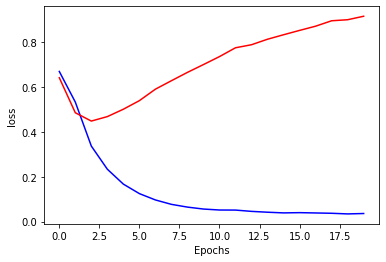

In [199]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

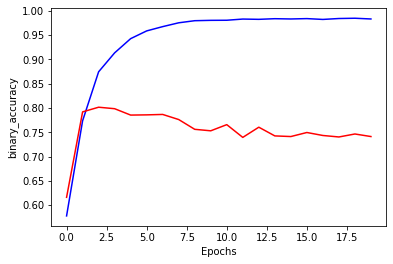

In [200]:
# Visualization of accuracy training 
plt.plot(history.history["binary_accuracy"], color="b")
plt.plot(history.history["val_binary_accuracy"], color="r")
plt.ylabel("binary_accuracy")
plt.xlabel("Epochs")
plt.show()

## Make predictions on test test

In [201]:
# load the test data and preprocess them as for model training
df_distweets_test = pd.read_csv("sample_data/test.csv", encoding='utf8')
df_distweets_test = df_distweets_test.loc[:, ['id', 'text']]
df_distweets_test['cleaned_tweets'] = df_distweets_test['text'].apply(lambda x: clean_text(x, STOP_WORDS, nlp, "http"))
df_distweets_test['encoded_tweets'] = tokenizer.texts_to_sequences(df_distweets_test.cleaned_tweets)

In [204]:
df_distweets_test.head()

,id,text,cleaned_tweets,encoded_tweets
0,0,Just happened a terrible car crash,happen terrible car crash,"[174, 1542, 44, 13]"
1,2,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[128, 172, 937, 120, 370, 1121]"
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save,"[118, 2, 521, 2790, 2093, 383, 97]"
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[389, 3092, 5952, 68]"
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,"[394, 523, 11, 4157, 339, 942]"


In [205]:
# check that the max sequence length is shorter than 25
max_seq_l = max(df_distweets_test['encoded_tweets'].apply(lambda x : len(x)))
if  max_seq_l < 25:
    df_distweets_test_pad = tf.keras.preprocessing.sequence.pad_sequences(df_distweets_test.encoded_tweets, padding = 'post', maxlen=max_pad)
else:
    print(f"Max sequence length is {max_seq_l} which is greater than {max_pad}")

In [206]:
df_distweets_test_pad[:5]

array([[ 174, 1542,   44,   13,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [ 128,  172,  937,  120,  370, 1121,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [ 118,    2,  521, 2790, 2093,  383,   97,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [ 389, 3092, 5952,   68,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [ 394,  523,   11, 4157,  339,  942,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]], dtype=int32)

In [208]:
df_distweets_test['model_preds'] = model.predict(df_distweets_test_pad)
df_distweets_test['target'] = df_distweets_test['model_preds'].apply(lambda x: 1 if x >= 0.5 else 0)
df_distweets_test.head()

102/102 [==============================] - 0s 1ms/step


,id,text,cleaned_tweets,encoded_tweets,model_preds,target
0,0,Just happened a terrible car crash,happen terrible car crash,"[174, 1542, 44, 13]",0.715160,1
1,2,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[128, 172, 937, 120, 370, 1121]",0.812372,1
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save,"[118, 2, 521, 2790, 2093, 383, 97]",0.992231,1
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[389, 3092, 5952, 68]",0.890180,1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,"[394, 523, 11, 4157, 339, 942]",0.998683,1


In [209]:
# get the predictions and ids for submission
predictions = df_distweets_test[['id', 'target']]
predictions.head(20)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [210]:
# Target distribution (in percent)
df_distweets_test['target'].value_counts()/len(df_distweets_test['target'])*100

0    62.825621
1    37.174379
Name: target, dtype: float64

In [211]:
# save the predictions to a csv file for submission
predictions.to_csv('submission.csv', header = True, index = False)